# Se importan las librerias

In [26]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
import nltk
import folium
# Se descarga el recurso 'punkt' para tokenizar o separar palabras
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Se importa el archivo "Metadata ML.csv" que está asociado a 1800 restaurantes de Miami filtrados

In [57]:
meta_2=pd.read_csv("Metadata ML.csv")

# Se importa el archivo "Metadata.csv" que se utilizará para medir los KPIs

In [2]:
meta=pd.read_csv("Metadata.csv")

In [3]:
meta.head()

,local_name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,apto_sillas_de_ruedas,atmosfera_agradable,apto_grupos_grandes,solo_efectivo,city
0,Domino's Pizza,"Domino's Pizza, 5769 NW 7th St Ste 22, Miami, ...",0x88d9b9847fc1d547:0xa69a99b892a3615d,25.778760,-80.290339,Restaurant,2.4,27,0,0,0,0,Miami
1,The Produce Connection,"The Produce Connection, 2200 NW 23rd St, Miami...",0x88d9b729d57eb3cd:0xc7ed59e9a4cff5fb,25.797904,-80.232051,Restaurant,3.3,3,0,0,0,0,Miami
2,Taco Bell,"Taco Bell, International Airport, Miami, FL 33126",0x88d9b9e2e5d1329d:0x614e7fdf2452832,25.796134,-80.278967,Restaurant,3.7,16,0,0,0,0,Miami
3,Arena's Burger Bar,"Arena's Burger Bar, 900 Biscayne Blvd Suite R1...",0x88d9b6a0fee2f1dd:0x9028448132310436,25.783089,-80.190133,Restaurant,3.9,8,0,0,0,0,Miami
4,Shawarmazing,"Shawarmazing, 17025 W Dixie Hwy, North Miami B...",0x88d9ad12d1acaa9d:0x9f080749822cf2d1,25.932135,-80.152832,Restaurant,4.1,8,0,0,0,0,Miami


# Se importa el archivo "data_filtrada.parquet" que posee un gran conjunto de palabras útiles para entrenar el modelo

In [4]:
meta_1=pd.read_parquet("data_filtrada.parquet")

# Se guardan las categorías únicas

In [5]:
categorias_existentes = meta_1['category'].unique()

# Se utiliza el algoritmo KernelDensity que busca la densidad en la coordenadas de los restaurantes

In [6]:
# Se obtienen las coordenadas de todos los restaurantes
coordenadas = meta[['latitude', 'longitude']].values

# Se inicializa el modelo de Kernel Density Estimation (KDE)
kde = KernelDensity(bandwidth=0.01, metric='haversine')

# Se ajusta el modelo a las coordenadas de los restaurantes
kde.fit(np.radians(coordenadas))

# Se calcula las densidades para todas las coordenadas de los restaurantes
densidades = kde.score_samples(np.radians(coordenadas))

# Se agregan la columna de densidad al DataFrame "meta"
meta['densidad'] = densidades


# Se muestran las categorías del dataset

In [7]:
categorias_existentes

array(['Korean restaurant', 'Restaurant',
       'Bakery, Health food restaurant', ...,
       'Bar & grill, Convenience store, Lottery retailer, Pizza delivery, Propane supplier, Sandwich shop',
       'Brazilian restaurant, Bistro, Brazilian pastelaria, Diner, Fast food restaurant, Pub, Restaurant',
       'Mexican restaurant, Bar, Pub, Restaurant'], dtype=object)

#Se cambia el formato de la columna "avg_rating" a numérico

In [8]:
meta['avg_rating'] = pd.to_numeric(meta['avg_rating'], errors='coerce')


# Se entrena un modelo de búsqueda de palabras similares llamado Word2Vec

In [9]:
# Primer conjunto  de datos (categorias_tokenizadas)
categorias_limpio = [re.sub(r'[^\w\s]', '', category) for category in categorias_existentes]
categorias_tokenizadas = [word_tokenize(category) for category in categorias_limpio]

# Se convierte el segundo conjunto de datos en una lista de listas de tokens
#cat_tokenizadas = [word_tokenize(category) for category in cat]

# Se combinan ambas listas de listas de tokens
#todos_tokens = categorias_tokenizadas

# Se entrena el modelo Word2Vec en todos los tokens
model = Word2Vec(categorias_tokenizadas, vector_size=300, window=5, min_count=5, sg=0)


# Se guarda el modelo entrenado con el dataset

In [10]:
model.save("modelo_word2vec.bin")

# Se prueba el algoritmo entrenado

In [59]:
# Se obtiene la palabra ingresada por el usuario
palabra = input("Ingresa una palabra: ")

# Se limpia la palabra ingresada por el usuario
palabra = re.sub(r'[^\w\s]', '', palabra)

# Se entrena la palabra más cercana según la similitud del coseno
try:
    palabra_similar, similaridad = model.wv.most_similar(palabra, topn=1)[0]
    print(f"La palabra más cercana a '{palabra}' es '{palabra_similar}' con una similitud de coseno de {similaridad:.2f}")

    # Se filtra las categorías que contienen la palabra similar
    categorias_con_palabra = [categoria for categoria in categorias_existentes if palabra_similar in categoria]

    # Se filtra el DataFrame 'meta' por las categorías encontradas
    meta_filtro = meta[meta['category'].isin(categorias_con_palabra)]

    # También se filtra por restaurantes que contengan la palabra buscada en la columna 'category'
    restaurantes_con_palabra = meta[meta['category'].str.contains(palabra, case=False)]
    meta_filtro = pd.concat([meta_filtro, restaurantes_con_palabra])

except KeyError:
    print(f"'{palabra}' no se ha logrado encontrar alguna asociación con la palabra ingresada.")



Ingresa una palabra: Mexican
La palabra más cercana a 'Mexican' es 'Taco' con una similitud de coseno de 0.87


## Se utiliza el algoritmo entrenado para mostrar los restaurantes más recomendados, utilizando la optimización de una suma ponderada, que vincula las características "densidad" "puntaje" y "número de reviews" con el metodo del descenso del gradiente

# Función a optimizar:

### puntuación restaurante = peso_puntaje * puntaje_normalizado + peso_densidad * densidad_normalizada + peso_nºreviews * nº_reviews_normalizado

In [60]:
# Pesos en el rango [0, 1]
initial_weights = [0.25, 0.25, 0.25]  # Valores iniciales de los pesos

# Se normalizan las columnas de puntuación, densidad y número de revisiones entre 0 y 1
scaler = MinMaxScaler()
meta_filtro['puntaje_normalizado'] = scaler.fit_transform(meta_filtro[['avg_rating']])
meta_filtro['densidad_normalizada'] = scaler.fit_transform(meta_filtro[['densidad']])
meta_filtro['num_of_reviews_normalizado'] = scaler.fit_transform(meta_filtro[['num_of_reviews']])

# Se define la función objetivo para minimizar
def objective_function(weights):
    puntuacion_restaurante = (
        weights[0] * meta_filtro['densidad_normalizada'] +
        weights[1] * meta_filtro['puntaje_normalizado'] +
        weights[2] * meta_filtro['num_of_reviews_normalizado']
    )
    return -puntuacion_restaurante.sum()

# Devuelve la suma negativa de la puntuación total que es equivalente que es equivalente a haber buscado la suma maxima positiva

# Se definen las restricciones de los pesos (en este caso, todos estánr entre 0 y 1)
constraints = [{'type': 'ineq', 'fun': lambda w: w[i]} for i in range(len(initial_weights))]

# Se optimizan los pesos usando el algoritmo de Descenso del Gradiente
result = minimize(objective_function, initial_weights, constraints=constraints)

# Se obtienen los pesos optimizados
optimized_weights = result.x

# Se calcula la puntuacion_restaurante con los pesos optimizados
meta_filtro['puntuacion_restaurante'] = (
    optimized_weights[0] * meta_filtro['densidad_normalizada'] +
    optimized_weights[1] * meta_filtro['puntaje_normalizado'] +
    optimized_weights[2] * meta_filtro['num_of_reviews_normalizado']
)

# Ordena el DataFrame en función de la puntuación restaurante en orden decreciente
meta_ordenado = meta_filtro.sort_values(by='puntuacion_restaurante', ascending=False)

In [70]:
meta_ordenado[["local_name","category","densidad_normalizada"]].head(15)

,local_name,category,densidad_normalizada
508,El King Taqueria Food Truck,Mexican restaurant,0.999969
1316,El Coyote,Mexican restaurant,0.999488
506,El Patio De Mexico,Mexican restaurant,0.999361
509,Bad Hombres Mexican Restaurant,Mexican restaurant,0.998392
531,Antojitos Mexicanos Tenorio,Mexican restaurant,0.994297
523,EL CAMION DEL TACO,Mexican restaurant,0.998068
1321,Taco Tacu,Mexican restaurant,1.000000
528,Mexico1810 Taqueria,Mexican restaurant,0.999833
515,Tacos & Tattoos Lincolns Beard,Mexican restaurant,0.998838
1314,Pilo's Street Tacos SoBe,Mexican restaurant,0.997800


# Se muestra el orden de importancia para cada característica

In [62]:
# Nombres de las características correspondientes
nombres = ['densidad', 'puntaje_normalizado', 'num_of_reviews']

# Crea un diccionario que asocie las características con sus pesos optimizados
dic = {nombres[i]: optimized_weights[i] for i in range(len(nombres))}

# Imprime el diccionario para ver el orden de importancia
print(dic)

{'densidad': 4.776809576943819e+33, 'puntaje_normalizado': 3.967258462458615e+33, 'num_of_reviews': 2.6267439151503403e+32}


# Es importante observar como el orden de iportancia de las características varía de acuerdo a la elección de palabra hecha por el usuario

# Se corrobora la independencia de las características utilizadas. Esto es importante para descartar características que puedan estar de más y sesgar el modelo

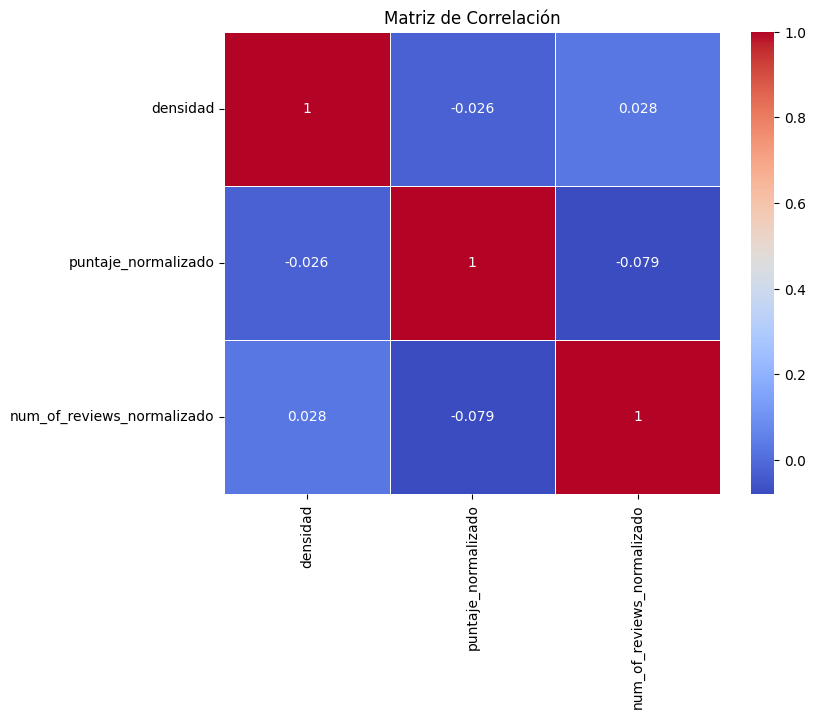

In [63]:
# Se calcula la matriz de correlación
corr = meta_filtro[['densidad', 'puntaje_normalizado', 'num_of_reviews_normalizado']].corr()

# Se crea un mapa de calor (heatmap) para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Se observa la correlación entre la puntuación de los restaurantes filtrados y cada característica usada

In [64]:
# Calcula las correlaciones entre "puntuacion_restaurante" y las tres columnas normalizadas
correlation_puntaje = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['puntaje_normalizado'])
correlation_densidad = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['densidad_normalizada'])
correlation_reviews = meta_filtro['puntuacion_restaurante'].corr(meta_filtro['num_of_reviews_normalizado'])

print(f"Correlación entre Puntuación del Restaurante y Puntaje Normalizado: {correlation_puntaje}")
print(f"Correlación entre Puntuación del Restaurante y Densidad Normalizada: {correlation_densidad}")
print(f"Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: {correlation_reviews}")


Correlación entre Puntuación del Restaurante y Puntaje Normalizado: 0.5949522212067971
Correlación entre Puntuación del Restaurante y Densidad Normalizada: 0.7875742654897403
Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: 0.005925359078183116


# Se Una vez que el usuario seleccionó el restaurante que quiere examinar, se buscan los que están alrededor de este

In [68]:
from geopy.distance import geodesic

# Se ingresa la entrada del usuario
nombre_ingresado = input("Ingrese el nombre del lugar: ")

# Se filtran los datos para obtener solo los restaurantes dentro del radio de 500 metros
restaurantes_cercanos = meta_2.copy()

# Se definen las coordenadas del lugar ingresado por el usuario
latitud_usuario = restaurantes_cercanos[restaurantes_cercanos['local_name'] == nombre_ingresado]['latitude'].iloc[0]
longitud_usuario = restaurantes_cercanos[restaurantes_cercanos['local_name'] == nombre_ingresado]['longitude'].iloc[0]

# Se calcula la distancia (euclidiana, las distancias son cortas) a cada restaurante en metros y agregarla como una nueva columna
restaurantes_cercanos['Distancia (m)'] = restaurantes_cercanos.apply(
    lambda row: geodesic((latitud_usuario, longitud_usuario), (row['latitude'], row['longitude'])).meters, axis=1
)

# Se convierte la distancia límite a un valor numérico (en metros)
distancia_limite_metros = 500

# Se filtran los restaurantes dentro del radio de 500 metros y con la misma categoría
restaurantes_cercanos = restaurantes_cercanos[
    (restaurantes_cercanos['Distancia (m)'] <= distancia_limite_metros)
]

# Se ordenan los restaurantes por distancia
restaurantes_cercanos = restaurantes_cercanos.sort_values(by='Distancia (m)')



Ingrese el nombre del lugar: El Coyote


# Se visualizan los resultados en una tabla

In [66]:
columnas=["local_name","category","Distancia (m)"]

In [ ]:
restaurantes_cercanos[columnas]

# Se genera un mapa para visualizar

In [56]:
# Se crea un mapa centrado en las coordenadas del usuario
mapa = folium.Map(location=[latitud_usuario, longitud_usuario], zoom_start=15)

# Se itera a través de los restaurantes cercanos y agrega marcadores rojos al mapa
for index, restaurante in restaurantes_cercanos.iterrows():
    folium.Marker(
        location=[restaurante['latitude'], restaurante['longitude']],
        popup=restaurante['local_name'],  # Puedes personalizar el contenido emergente
        icon=folium.Icon(color='red')
    ).add_to(mapa)

# Se guarda el mapa como un archivo HTML
mapa.save('restaurantes_cercanos_mapa.html')